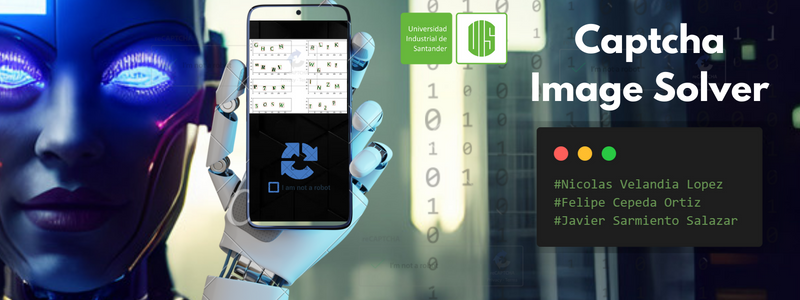

In [ ]:
#@title Importamos librerías y dataset
from google.colab import drive
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import imutils


from sklearn.model_selection import train_test_split
!pip -qq install --upgrade --no-cache-dir gdown
#!gdown -qq 1Eah-L7U0ViUcVygoqq4zTIeKscoHEuDc
!gdown -qq 1n2QDZrpIYW-snkjQmvYnqtdTOoYHu5Wp
#!unzip -q /content/drive/MyDrive/proyecto_ia/archive.zip -d captcha-images
!unzip -qq archive2.zip -d captcha-images

# Red Neuronal Convolucional
![Convolutional Neural Network](https://s1.eestatic.com/2017/12/14/actualidad/actualidad_269487281_130081577_1096x294.jpg)


# Vistazo a nuestro dataset

In [ ]:
#@title Cantidad de imágenes
src_dir = '/content/captcha-images/captcha_images'

img_paths = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png','.jpg', '.jpeg'))]
print("Total de imágenes del dataset:", len(img_paths))
print(img_paths[0:20])

Total de imágenes del dataset: 4000
['2H4H.png', '7BUX.png', 'E7Y3.png', 'ETAB.png', '4P4S.png', '5Y6U.png', 'WM7F.png', '2LIW.png', '3CUJ.png', '6CFV.png', '9KWE.png', '244V.png', 'VUQB.png', 'JIN8.png', '9JHL.png', 'XNZH.png', 'JAG1.png', 'HYFD.png', '9B8X.png', '13N5.png']


<Figure size 720x720 with 0 Axes>

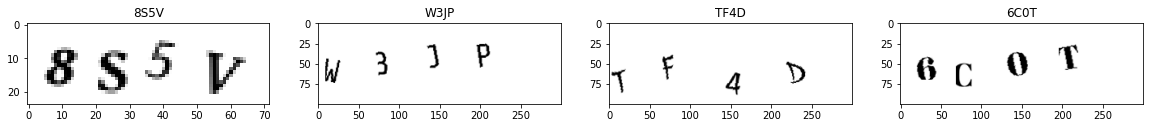

In [ ]:
#@title CAPTCHAS y sus labels
plt.figure(figsize=(10,10))
figs, axs = plt.subplots(1,4, figsize=(20,20))
for i in range(4):
  index = random.randint(0, len(img_paths))
  img = cv2.imread(os.path.join(src_dir, img_paths[index]))
  axs[i].imshow(img)
  axs[i].title.set_text(img_paths[index].split('.')[0])

In [ ]:
#@title Cargamos los labels y contamos los caracteres
labels = [img_path.split(".")[0] for img_path in img_paths]

char_counts = {}
for label in labels:
    for char in label:
        if char not in char_counts:
            char_counts[char] = 1
        else:
            char_counts[char] += 1

char_counts = sorted(char_counts.items())

chars = [char_count[0] for char_count in char_counts]
counts = [char_count[1] for char_count in char_counts]

chars.reverse()
counts.reverse()

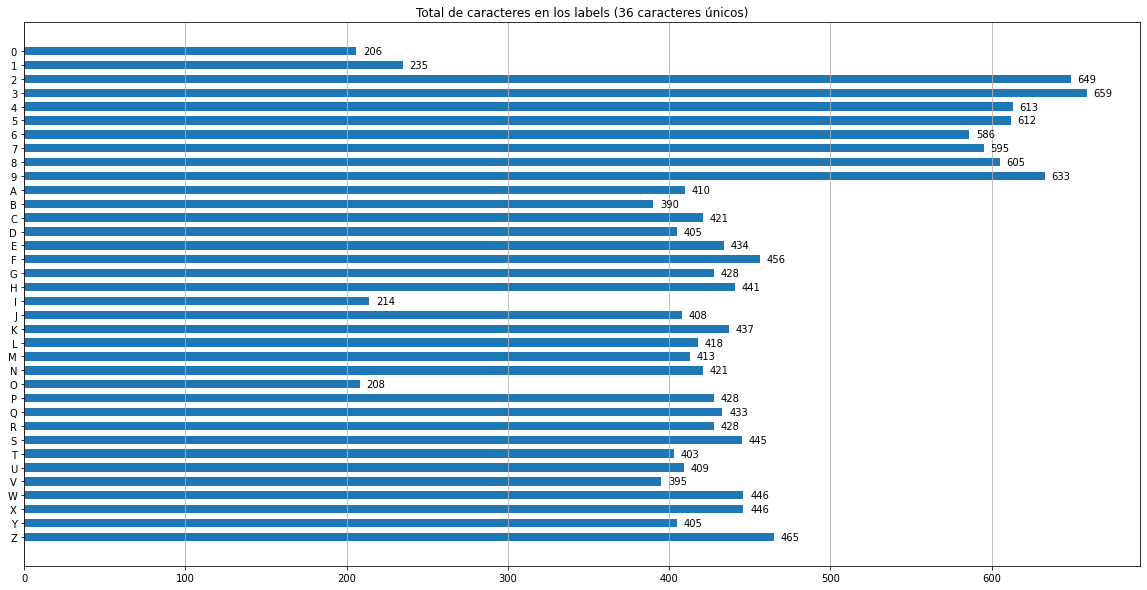

In [ ]:
#@title Algunas estadísticas
plt.figure(figsize=(20, 10))

bars = plt.barh(y=chars, width=counts, height=0.6)
for bar in bars:
    w = bar.get_width()
    y = bar.get_y()
    h = bar.get_height()
    plt.text(w+10, y+h/2, w, ha='center', va='center')
    
#plt.xlim(1100, 1400)
plt.grid(linestyle='-', axis='x')
plt.title(f'Total de caracteres en los labels ({len(chars)} caracteres únicos)')
plt.show()

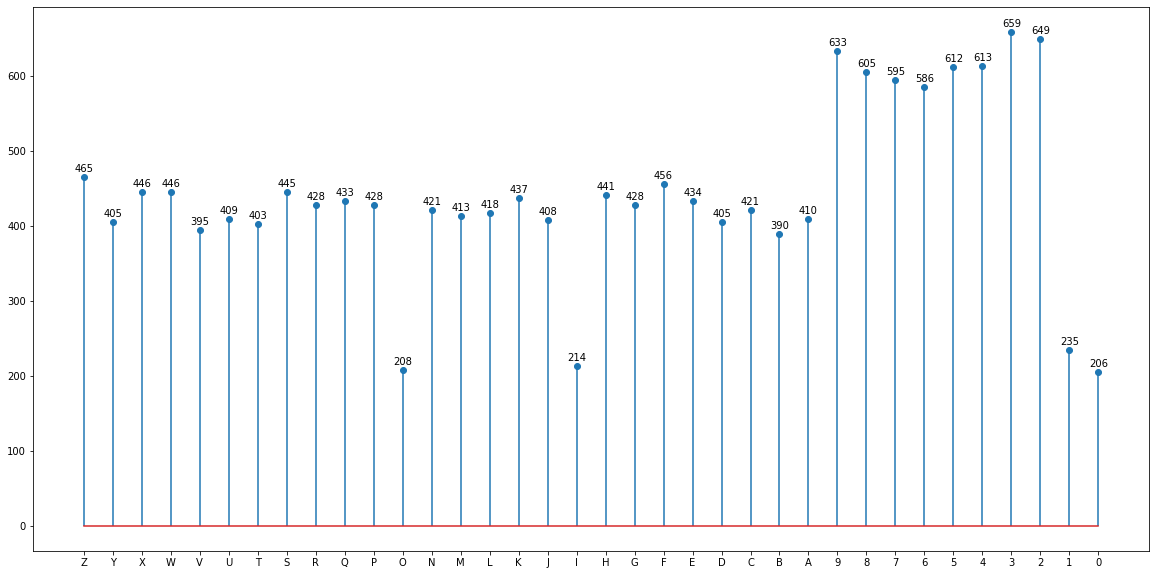

In [ ]:
plt.figure(figsize=(20, 10))
stem = plt.stem(chars, counts, use_line_collection=True)
for x,y in zip(chars, counts):
    plt.annotate('{:.0f}'.format(y), xy=(x,y), xytext=(0,5), textcoords='offset points',ha='center')
#plt.ylim(1100, 1400)
plt.show()

# ¿Cómo procesaremos las imágenes?




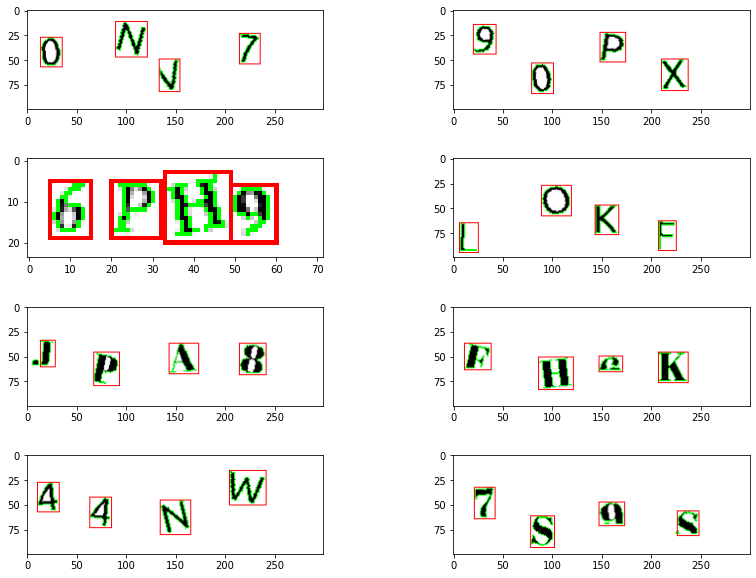

In [ ]:
#@title Visualización de la delimitación y reconocimiento de los caracteres
# Initialize figure with 4 rows and 2 columns
fig = plt.figure(figsize=(14, 10))
plt.subplots_adjust(hspace=0.5)

# Iterate over subplots
for i in range(4 * 2):
    # Initialize subplot
    ax = plt.subplot(4, 2, i + 1)
    
    # Select random image from the list of image paths
    img_index = np.random.randint(0, len(img_paths))
    img_path = os.path.join(src_dir, img_paths[img_index])
    
    # Load and preprocess image
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)
    bit_not = cv2.bitwise_not(thresh)
    
    # Find contours in the image
    contours, hierarchy = cv2.findContours(bit_not, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Draw contours on the original image
    cv2.drawContours(img, contours, -1, (0, 255, 0), 1)
    
    # Get bounding rectangles for each contour
    rects = [cv2.boundingRect(c) for c in contours]
    
    # If there are fewer than 4 rectangles, split the widest rectangle in half
    # and append the two halves to the list of rectangles
    while len(rects) < 4:
        wide_rect = rects.pop()
        x, y, w, h = wide_rect
        first_half = (x, y, w // 2, h)
        second_half = (x + w // 2, y, w // 2, h)
        rects.append(first_half)
        rects.append(second_half)
      
    while len(rects) > 4:
        wide_rect = rects.pop(0)
    
    # Draw bounding rectangles on the image
    for rect in rects:
        x, y, w, h = rect
        cv2.rectangle(img, (x - 1, y - 1), (x + w + 1, y + h + 1), (255, 0, 0), 1)
    
    # Display image
    plt.imshow(img)

# **Preprocesamiento**

In [ ]:
#@title Funciones necesarias para preprocesar las imágenes
captcha_images_folder = "/content/captcha-images/captcha_images"

captchas = [
    os.path.join(captcha_images_folder, f) for f in os.listdir(captcha_images_folder)
]

def preprocess_CAPTCHA(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Add a border to the image
    gray_with_border = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    
    # Apply thresholding to the image
    preprocessed = cv2.threshold(gray_with_border, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    return gray_with_border, preprocessed

def get_CAPTCHA_label(path_to_file):
    filename = os.path.basename(path_to_file)
    label = filename.split(".")[0]
    return label

def find_bounding_rectangles_of_contours(contours):
    # Initialize an empty list to store the bounding rectangles for each contour
    bounding_rectangles = []
    
    # Iterate over the contours
    for contour in contours:
        # Get the bounding rectangle for the contour
        (x, y, w, h) = cv2.boundingRect(contour)
        rects = cv2.boundingRect(contour)
        
        # If the width-to-height ratio of the bounding rectangle is greater than 1.25,
        # split the rectangle into two separate rectangles with equal widths
        if w/h > 1.25:
            half_width = int(w/2)
            bounding_rectangles.append((x, y, half_width, h))
            bounding_rectangles.append((x+half_width, y, half_width, h))
        # Otherwise, append the bounding rectangle as is
        else:
            bounding_rectangles.append((x, y, w, h))
    
    return bounding_rectangles

def CAPTCHA_to_gray_scale_and_bounding_rectangles(captcha_image_file):
    # Read the CAPTCHA image from the file
    image = cv2.imread(captcha_image_file)
    
    # Preprocess the image to remove noise and highlight the characters
    gray, preprocessed = preprocess_CAPTCHA(image)
    
    # Find the contours in the preprocessed image
    contours = cv2.findContours(preprocessed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    
    # Find the bounding rectangles for the contours
    bounding_rectangles = find_bounding_rectangles_of_contours(contours)
    
    # Sort the bounding rectangles by the x-coordinate of the top-left corner
    bounding_rectangles = sorted(bounding_rectangles, key=lambda x: x[0])
    
    return gray, bounding_rectangles

def bounding_rectangle_to_letter_image(letter_bounding_box, grayscaled):
    # Unpack the bounding box coordinates
    x, y, w, h = letter_bounding_box

    # Crop the grayscale image using the bounding box coordinates
    letter_image = grayscaled[y-2:y+h+2, x-2:x+w+2]
    
    return letter_image

captcha_processing_output_folder = "/content/extracted_letter_images"
character_counts = {}

def save_letter_images(letter_bounding_rectangles, gray, captcha_label):
    #Saves the individual letters of a CAPTCHA to the specified output folder.

    # Iterate over the bounding rectangles and corresponding letters
    for letter_bounding_rectangle, current_letter in zip(letter_bounding_rectangles, captcha_label):
        # Convert the bounding rectangle to a letter image
        letter_image = bounding_rectangle_to_letter_image(letter_bounding_rectangle, gray)

        # Create the save path for the current letter
        save_path = os.path.join(captcha_processing_output_folder, current_letter)
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Get the current count for the current letter, or default to 1 if it doesn't exist
        character_count = character_counts.get(current_letter, 1)

        # Save the letter image to the specified path
        p = os.path.join(save_path, str(character_count) + ".png")
        try:
          cv2.imwrite(p, letter_image)
        except:
          letter_image
        

        # Increment the character count for the current letter
        character_counts[current_letter] = character_count + 1

In [ ]:
#@title Convertimos las imágenes a escala de grises y obtenemos los rectángulos de delimitación
for captcha_image_file in captchas:
    # Get the label for the current CAPTCHA image
    captcha_label = get_CAPTCHA_label(captcha_image_file)

    # Convert the CAPTCHA image to grayscale and get the bounding rectangles for the letters
    gray, letter_bounding_rectangles = CAPTCHA_to_gray_scale_and_bounding_rectangles(captcha_image_file)

    # Skip the current CAPTCHA image if it doesn't have exactly 4 letters
    if( len(letter_bounding_rectangles) != 4):
        continue
    # Save the individual letters of the current CAPTCHA image
    save_letter_images(letter_bounding_rectangles,gray,captcha_label)

In [ ]:
#@title Redimensionamos las imágenes y las leemos

captcha_processing_output_folder = "/content/extracted_letter_images"

def resize_image_to_dimensions(image, desired_width, desired_height):
    #Resizes an image to the desired dimensions

    # Get the current dimensions of the image
    (h, w) = image.shape[:2]

    # Check the aspect ratio of the image
    if w > h:
         # Landscape image: resize to the desired width
        image = imutils.resize(image, width=desired_width)
    else:
        # Portrait image: resize to the desired height
        image = imutils.resize(image, height=desired_height)
    
    # Calculate the amount of padding needed to fit the image within the desired dimensions
    pad_width = int((desired_width - image.shape[1]) / 2.0)
    pad_height = int((desired_height - image.shape[0]) / 2.0)

    # Add the padding to the image using the cv2.copyMakeBorder function
    image_with_border = cv2.copyMakeBorder(
        image, pad_height, pad_height, pad_width, pad_width, cv2.BORDER_REPLICATE
    )

    # Resize the padded image to the desired dimensions
    image_with_border_resized = cv2.resize(
        image_with_border, (desired_width, desired_height)
    )

    return image_with_border_resized

def read_image(image_file_path):
    img = cv2.imread(image_file_path)
    # Convert the image to grayscale using the cv2.cvtColor function
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Resize the image to the desired dimensions
    img = resize_image_to_dimensions(img, 20, 20)
    # Add a new axis to the image to make it a single-channel image
    img = np.expand_dims(img, axis=2)
    return img

In [ ]:
#@title Obtenemos los caracteres separados y sus labels
images = []
labels = []
from imutils import paths
for image_file_path in imutils.paths.list_images(captcha_processing_output_folder):
    # Read and process the image file
    image_file = read_image(image_file_path)

    # Extract the label from the file path
    label = image_file_path.split(os.path.sep)[-2]

    # Flatten the image and append it to the images list
    images.append(image_file.flatten())

    # Append the label to the labels list
    labels.append(label)

<Figure size 720x720 with 0 Axes>

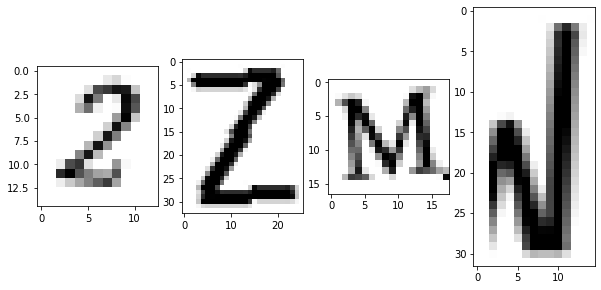

In [ ]:
#@title Visualización de una letra separada
folder_path = '/content/extracted_letter_images'
subfolders = [f.name for f in os.scandir(folder_path) if f.is_dir()]
random_subfolders = random.sample(subfolders, 4)
import glob
imgs = []

for subfolder in random_subfolders:
  # Navega hasta la subcarpeta
  subfolder_path = os.path.join(folder_path, subfolder)
  os.chdir(subfolder_path)

  # Obtiene una lista de todas las imágenes en la subcarpeta
  image_files = glob.glob('*.png')

  # Elegir aleatoriamente una imagen de la lista
  random_image = random.choice(image_files)

  # Obtiene el path completo de la imagen
  image_path = os.path.join(subfolder_path, random_image)

  # Añade la imagen a la lista
  imgs.append(image_path)

plt.figure(figsize=(10,10))
figs, axs = plt.subplots(1,4, figsize=(10,10))
axs[0].imshow(cv2.imread(imgs[0]))
axs[1].imshow(cv2.imread(imgs[1]))
axs[2].imshow(cv2.imread(imgs[2]))
axs[3].imshow(cv2.imread(imgs[3]))
plt.show()

In [ ]:
#@title Normalizamos las imágenes
# Normalize the pixel values of the images by dividing by 255
images = np.array(images, dtype="float") / 255.0

# Convert the labels list to a numpy array
labels = np.array(labels)

# Métodos de clasificación

In [ ]:
#@title Se dividen los datos para entrenamiento y testeo

testing_size = 0.25 #@param {type:"number"}

# Split the images and labels into training and test sets using the train_test_split function
(X_train, X_test, y_train, y_test) = train_test_split(
    images, labels, test_size=testing_size, random_state=42
)
ac = []
methods = ["GNB", "DTC", "RFC", "SVC"]

In [ ]:
#@title **GaussianNB**

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score   

estimator = GaussianNB()
estimator.fit(X_train, y_train)
predictions = estimator.predict(X_train)
accuracy = accuracy_score(estimator.predict(X_test), y_test)
ac.append(accuracy)
print("Accuracy score: %.3f"%accuracy_score(estimator.predict(X_test), y_test))

Accuracy score: 0.672


In [ ]:
#@title **Decision Tree Classifier**

from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier(max_depth=None, random_state=42)
estimator.fit(X_train, y_train)
predictions = estimator.predict(X_test)
accuracy = accuracy_score(estimator.predict(X_test), y_test)
ac.append(accuracy)
print("Accuracy score: %.3f"%accuracy)
print('DecisionTreeClassifier max_depth: {}'.format(estimator.tree_.max_depth))

Accuracy score: 0.902
DecisionTreeClassifier max_depth: 21


In [ ]:
#@title **Random Forest Classifier**

from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=42)
estimator.fit(X_train, y_train)
predictions = estimator.predict(X_test)
accuracy = accuracy_score(estimator.predict(X_test), y_test)
ac.append(accuracy)
print("Accuracy score: %.3f"%accuracy)

Accuracy score: 0.974


In [ ]:
#@title **Support Vector Classification (SVC)**

from sklearn.svm import SVC

print("Accuracy score:")
kernels = ['rbf', 'linear', 'poly', 'sigmoid']
accuracys = []
for i in kernels:
  estimator = SVC(kernel=i, random_state=42)
  estimator.fit(X_train, y_train)
  predictions=estimator.predict(X_test)
  accuracys.append(accuracy_score(predictions, y_test))
ac.append(max(accuracys))
j = 0
for i in kernels: 
  print(i, accuracys[j])
  j = j + 1

Accuracy score:
rbf 0.975037147102526
linear 0.9803863298662704
poly 0.9836552748885586
sigmoid 0.04071322436849926


¿Cúal de estos kernels de SVC tuvo mayor puntaje?



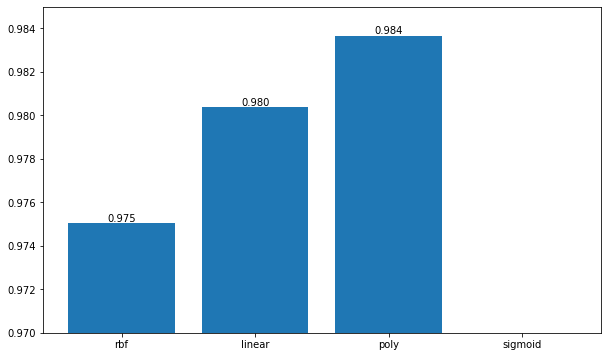

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(kernels, accuracys, width=0.8)
for x, y in zip(kernels, accuracys[0:3]):
    plt.text(x, y, f'{y:.3f}', ha='center', va='bottom')
plt.ylim(0.97, 0.985)
plt.show()

**El kernel poly obtuvo el mejor puntaje**

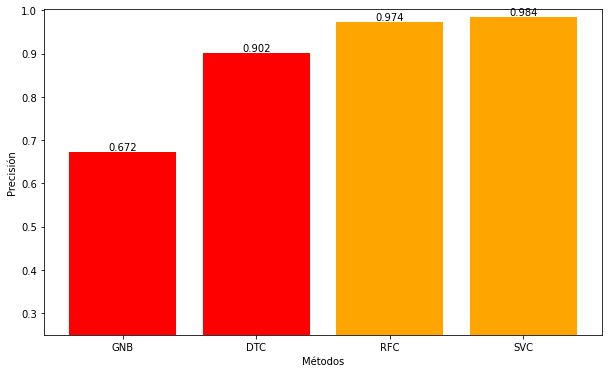

In [ ]:
#@title Ahora comparemos los diferentes métodos de clasificación
plt.figure(figsize=(10, 6))
plt.bar(methods, ac, width=0.8)
for i, val in enumerate(ac):
    if val >= 0.99:
        color = 'green'
    elif val >= 0.95:
        color = 'orange'
    else:
        color = 'red'
    plt.bar(methods[i], val, color=color)
for x, y in zip(methods, ac):
    plt.text(x, y, f'{y:.3f}', ha='center', va='bottom')
plt.xlabel('Métodos')
plt.ylabel('Precisión')
plt.ylim(0.25, 1.004)
plt.show()

# Red Neuronal Convolucional

### Preparamos los datos para entrenar a la red neuronal

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
y_train = np.array(y_train)
print("Train images shape:", X_train.shape)
print("Test images shape: ", X_test.shape)

Train images shape: (10093, 400)
Test images shape:  (3365, 400)


Transformamos las imágenes, su nueva forma es de 20x20 píxeles en escala de grises, esto nos permite darlas como entrada para nuestra red neuronal

In [ ]:
X_train = X_train.reshape([-1, 20,20, 1])
X_test = X_test.reshape([-1, 20,20, 1])
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('x_train shape:', X_train.shape)


print('Número de imágenes en x_train: ', X_train.shape[0])
print('Número de imágenes en x_test: ', X_test.shape[0])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

x_train shape: (10093, 20, 20, 1)
Número de imágenes en x_train:  10093
Número de imágenes en x_test:  3365
(10093, 20, 20, 1) (10093,) (3365, 20, 20, 1) (3365,)


Transformamos las etiquetas a formato binario, usando LabelBinarizer

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_train = label_binarizer.transform(y_train)
y_test = label_binarizer.transform(y_test)

# La clase LabelBinarizer también puede usarse para transformar las etiquetas binarias de vuelta a su formato original
y_test0 =  label_binarizer.inverse_transform(y_test)

In [ ]:
#@title Nuestro modelo de red neuronal convolucional

# Importamos las clases necesarias del paquete Keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense

# Definimos el número de clases que se van a predecir
num_classes = 36

# Creamos una instancia de un modelo secuencial de Keras
CNN_model = Sequential()

# Agregamos la capa de convolución con 20 filtros, un tamaño de filtro de 5x5, función de activación ReLU y "padding" para mantener el tamaño de imagen.
CNN_model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))

# Agregamos la capa de pooling para reducir la dimensionalidad de las características aprendidas por la capa de convolución
CNN_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Agregamos otra capa de convolución con 50 filtros, un tamaño de filtro de 5x5, función de activación ReLU y "padding" para mantener el tamaño de imagen.
CNN_model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))

# Agregamos otra capa de pooling para reducir la dimensionalidad de las características aprendidas por la capa de convolución
CNN_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Aplanamos la salida de la capa de pooling y pasarla a una capa densa
CNN_model.add(Flatten())

# Agregamos una capa densa con 512 neuronas y función de activación ReLU
CNN_model.add(Dense(512, activation="relu"))

# Agregamos una capa densa con un número de neuronas igual al número de clases, y función de activación Softmax para que las salidas de la red sean probabilidades de cada clase
CNN_model.add(Dense(num_classes, activation="softmax"))

# Compilamos el modelo usando la función de pérdida de entropía cruzada categórica, el optimizador Adam y la métrica de precisión
CNN_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 20)        520       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 50)        25050     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 50)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1250)              0         
                                                                 
 dense (Dense)               (None, 512)               6

Entrenamos el modelo usando los datos de entrenamiento y validación

In [ ]:
history = CNN_model.fit(
    X_train,                 # Los datos de entrenamiento de imágenes
    y_train,                 # Las etiquetas de entrenamiento de las imágenes
    validation_data=(X_test, y_test),  # Los datos de validación y sus etiquetas
    batch_size=16,           # El número de muestras por actualización de los parámetros del modelo
    epochs=5,                # El número de veces que el modelo verá todos los datos de entrenamiento
    verbose=1,               # El nivel de registro de la información del entrenamiento en la consola
)

Epoch 1/5
631/631 [==============================] - 23s 35ms/step - loss: 0.6951 - accuracy: 0.8211 - val_loss: 0.1761 - val_accuracy: 0.9501
Epoch 2/5
631/631 [==============================] - 18s 29ms/step - loss: 0.1176 - accuracy: 0.9678 - val_loss: 0.1302 - val_accuracy: 0.9652
Epoch 3/5
631/631 [==============================] - 20s 31ms/step - loss: 0.0725 - accuracy: 0.9780 - val_loss: 0.0700 - val_accuracy: 0.9807
Epoch 4/5
631/631 [==============================] - 24s 38ms/step - loss: 0.0462 - accuracy: 0.9850 - val_loss: 0.0787 - val_accuracy: 0.9747
Epoch 5/5
631/631 [==============================] - 22s 35ms/step - loss: 0.0401 - accuracy: 0.9884 - val_loss: 0.0851 - val_accuracy: 0.9801


## 

In [ ]:
#@title Guardamos nuestro modelo
CNN_model.save('/content/model_captcha_saved.h5')

## Graficamos loss vs accuracy para entrenamiento y validación

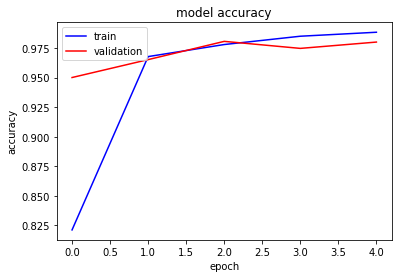

In [ ]:
plt.plot(history.history['accuracy'], color='b')
plt.plot(history.history['val_accuracy'], color='r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

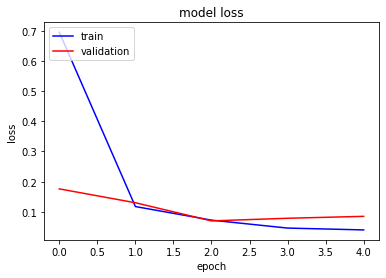

In [ ]:
plt.plot(history.history['loss'], color='b')
plt.plot(history.history['val_loss'], color='r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#@title Clases de nuestro dataset, 26 letras y 10 números
np.unique(labels)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype='<U1')

## Evaluamos nuestro modelo

In [ ]:

test_loss, test_acc = CNN_model.evaluate(X_test, y_test)

print( 'Test accuracy:', test_acc, " test_loss: ", test_loss)

106/106 [==============================] - 2s 22ms/step - loss: 0.0851 - accuracy: 0.9801
Test accuracy: 0.9800891280174255  test_loss:  0.08510342240333557


In [ ]:
predictions = CNN_model.predict(X_test)
print(predictions[23])
print("valor predicho:",  np.argmax(predictions[23]), "max prob: ", np.max(predictions[23]),
      "ground truth: ", y_test0[23] )

106/106 [==============================] - 2s 15ms/step
[2.0856834e-10 3.3907545e-05 4.4135143e-10 2.7762164e-16 4.9123304e-07
 2.7318612e-09 1.5282097e-08 1.9469383e-11 7.7112101e-11 7.4685240e-13
 3.5308858e-08 8.1846370e-11 5.9840415e-05 9.0776737e-08 3.3358006e-06
 4.4226067e-10 1.1560415e-09 5.1676530e-10 3.5207498e-07 1.3537748e-07
 1.2473925e-05 9.9960524e-01 2.0791211e-07 1.5613677e-08 8.6192095e-08
 1.9506612e-09 6.5570271e-07 1.1172374e-11 1.9382365e-13 1.7202115e-09
 2.8119903e-04 1.5627844e-06 1.5289946e-07 9.8808883e-10 1.6509071e-07
 8.1009794e-09]
valor predicho: 21 max prob:  0.99960524 ground truth:  L


### Cargamos el modelo que habíamos guardado anteriormente, esto para que no sea necesario volver a entrenar cuando el entorno se desconecte

In [ ]:
from tensorflow.keras.models import load_model
CNN_model = load_model('/content/model_captcha_saved.h5')

In [ ]:
CAPTCHA = "/content/captcha-images/captcha_images/0A0E.png"

def find_bounding_rectangles_of_contours(contours):
    """Determines the bounding rectangles of the contours of the cropped letters."""
    letter_bounding_rectangles = []
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if w / h > 1.25:
            half_width = int(w / 2)
            letter_bounding_rectangles.append((x, y, half_width, h))
            letter_bounding_rectangles.append((x + half_width, y, half_width, h))
        else:
            letter_bounding_rectangles.append((x, y, w, h))
    return letter_bounding_rectangles


def preprocess_CAPTCHA(img):
    """Takes a CAPTCHA image and thresholds it."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_with_border = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    preprocessed = cv2.threshold(
        gray_with_border, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
    )[1]
    return gray_with_border, preprocessed


def get_CAPTCHA_label(path_to_file):
    """Get the CAPTCHA text from the file name."""
    filename = os.path.basename(path_to_file)
    label = filename.split(".")[0]
    return label


def CAPTCHA_to_gray_scale_and_bounding_rectangles(captcha_image_file):
    """Take a CAPTCHA and output a grayscale version as well as the bounding rectangles of its cropped letters."""
    image = cv2.imread(captcha_image_file)
    gray, preprocessed = preprocess_CAPTCHA(image)
    contours = cv2.findContours(
        preprocessed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    contours = contours[0]
    letter_bounding_rectangles = find_bounding_rectangles_of_contours(contours)
    letter_bounding_rectangles = sorted(letter_bounding_rectangles, key=lambda x: x[0])
    return gray, letter_bounding_rectangles


In [ ]:
captcha_label = get_CAPTCHA_label(CAPTCHA)
gray, letter_bounding_rectangles = CAPTCHA_to_gray_scale_and_bounding_rectangles(
    CAPTCHA
)
predictions = []

In [ ]:
for letter_bounding_rectangle in letter_bounding_rectangles:
    x, y, w, h = letter_bounding_rectangle
    letter_image = gray[y - 4 : y + h + 4, x - 4 : x + w + 4]
    letter_image = resize_image_to_dimensions(letter_image, 20, 20)
    letter_image = np.expand_dims(letter_image, axis=2)
    letter_image = np.expand_dims(letter_image, axis=0)
    prediction = CNN_model.predict(letter_image)
    letter = label_binarizer.inverse_transform(prediction)[0]
    predictions.append(letter)

1/1 [==============================] - 0s 18ms/step


predicted CAPTCHA text is: 0A0E
captch text is: 0A0E


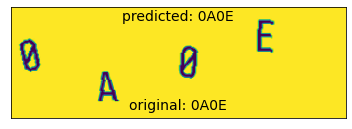

In [ ]:
predicted_captcha_text = "".join(predictions)
orig = CAPTCHA.split("/")[-1].split(".")[0]
print(f"predicted CAPTCHA text is: {predicted_captcha_text}")
print(f"captch text is: {orig}")
img = plt.imread(CAPTCHA)
fig, ax = plt.subplots()
ax.imshow(img)
ax.text(0.5, 0.88, "predicted: "+predicted_captcha_text, transform=ax.transAxes,
        fontsize=14, ha='center', color='black')
ax.text(0.5, 0.08, "original: "+orig, transform=ax.transAxes,
        fontsize=14, ha='center', color='black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

/content/1B7U.png


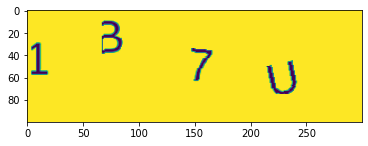

In [ ]:
#@title Generando nuevas imágenes para probar nuestra red neuronal

import random
from PIL import Image, ImageDraw, ImageFont, ImageFilter

# define captcha image size and font size

CAPTCHA_WIDTH = 300
CAPTCHA_HEIGHT = 100
FONT_SIZE = 40

# define possible characters for captcha
CHARACTERS = 'abcdefghijklmnopqrstuvwxyz0123456789'.upper()

# define function to generate random string of characters
def random_string(length):
    return ''.join(random.choice(CHARACTERS) for i in range(length))

fontpath = 'LiberationSans-Regular.ttf'

# create a new image object for each letter
letters = []
chars = []
for i in range(4):
    letter_image = Image.new('RGBA', (FONT_SIZE+20, FONT_SIZE+20), (0, 0, 0, 0))
    letter_draw = ImageDraw.Draw(letter_image)
    font = ImageFont.truetype(fontpath, FONT_SIZE)
    char = random.choice(CHARACTERS)
    chars.append(char)
    letter_draw.text((0, 0), char, font=font, fill=(0, 0, 0))
    angle = random.randint(-15, 15)
    letter_image = letter_image.rotate(angle, expand=1)
    x_scale = random.uniform(0.7, 1.3)
    y_scale = random.uniform(0.7, 1.3)
    x_offset = random.uniform(-10, 10)
    y_offset = random.uniform(-10, 10)
    letter_image = letter_image.transform((int(FONT_SIZE+10*x_scale), int(FONT_SIZE+10*y_scale)), Image.AFFINE, (1, 0, x_offset, 0, 1, y_offset), resample=Image.BICUBIC)
    letters.append(letter_image)

# create a new image object for the captcha
image = Image.new('RGBA', (CAPTCHA_WIDTH, CAPTCHA_HEIGHT), (255, 255, 255, 255))

# paste the letter images onto the captcha image
x_offset = 0
for letter_image in letters:
    w, h = letter_image.size
    x = x_offset + random.randint(0, 10)
    y = random.randint(0, CAPTCHA_HEIGHT - h)
    image.paste(letter_image, (x, y), letter_image)
    x_offset += w + random.randint(10, 20)

# convert the image to grayscale
image = image.convert('L')

# save the image to a file
image.save("/content/"+"".join(chars)+'.png')

image_path = '/content/'+"".join(chars)+'.png'
print(image_path)
img = plt.imread(image_path)
fig, ax = plt.subplots()
ax.imshow(img)
plt.show()

In [ ]:
#@title Hacemos la predicción
captcha_label = get_CAPTCHA_label(image_path)
gray, letter_bounding_rectangles = CAPTCHA_to_gray_scale_and_bounding_rectangles(
    image_path
)
predictions = []
for letter_bounding_rectangle in letter_bounding_rectangles:
    x, y, w, h = letter_bounding_rectangle
    letter_image = gray[y - 5 : y + h + 5, x - 5 : x + w + 5]
    letter_image = resize_image_to_dimensions(letter_image, 20, 20)
    letter_image = np.expand_dims(letter_image, axis=2)
    letter_image = np.expand_dims(letter_image, axis=0)
    prediction = CNN_model.predict(letter_image)
    letter = label_binarizer.inverse_transform(prediction)[0]
    predictions.append(letter)
print(predictions)

1/1 [==============================] - 0s 19ms/step
['1', 'B', '7', 'U']


predicted CAPTCHA text is: 1B7U
captch text is: 1B7U


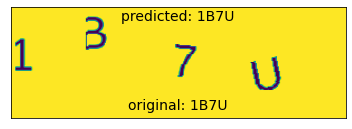

In [ ]:
predicted_captcha_text = "".join(predictions)
orig = image_path.split("/")[-1].split(".")[0]
print(f"predicted CAPTCHA text is: {predicted_captcha_text}")
print(f"captch text is: {orig}")
img = plt.imread(image_path)
fig, ax = plt.subplots()
ax.imshow(img)
ax.text(0.5, 0.88, "predicted: "+predicted_captcha_text, transform=ax.transAxes,
        fontsize=14, ha='center', color='black')
ax.text(0.5, 0.08, "original: "+orig, transform=ax.transAxes,
        fontsize=14, ha='center', color='black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()